In [1]:
# process_image.ipynb
# Created 2-10-20 by Eric Graves
# Process an image to "skullphone-ize" it.

## Imports and environment setup

In [9]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import sys

%matplotlib inline

# DEBUG shows input and output images, DEBUG_VERBOSE shows images and sizes at each step
DEBUG = False 

# This parameter sets how much the image is scaled before processing: 
#-- Smaller image ==> more loss, but faster processing
#-- Just divides the image dimensions in pixels, for best quality values are between 1 and 10. Any smaller and there is a lot of loss of detail/accent colors.
IMAGE_SCALE = 20
    
# Single test image name
TEST_IMAGE = 'planets.jpg' #'lighthouse.jpg'#'IMG_3723_ART.PNG'# Brockhampton Saturation III album art

## Single Cell Refactored Implementation:

In [10]:
def skullphonize_img(img_path, img_scale):
    
    # Read image, set size
    try:
        img = plt.imread(img_path, 0)
        img_PIL = Image.open(img_path)          # image opened in RGBA format: size=(x, y, 4[RGBA])
    except IOError:
        return None
    
    w, h = img.shape[:2]

    # Enforce square image: add padding to make image square in the maximum dimension?

    # Resize image
    img_resized = img_PIL.resize(((int)(h/img_scale), (int)(w/img_scale)))
    img_rs_px = np.array(img_resized)         # as numpy array
    w_rs, h_rs = img_rs_px.shape[:2]          # these are the number of clusters in each dimension

    # Cluster dimension
    cluster_d = 30

    # Decide circle center offsets: as percentages of d
    r_off = np.array((0.27, 0.5))
    b_off = np.array((0.73, 0.25))
    g_off = np.array((0.73, 0.75))            # TODO: rewrite as single array

    # Find circle centers as (x,y)
    r_xy = np.uint8(cluster_d * r_off)
    b_xy = np.uint8(cluster_d * b_off)
    g_xy = np.uint8(cluster_d * g_off)

    # Find maximum allowable circle radius
    rad_max = np.uint8(0.22* cluster_d)
    rad_min = 0                               # single px as min

    # Placeholder for output image:
    out_img = np.empty((1,cluster_d * w_rs,3))             # single px high, (cluster size)x(# clusters wide) wide

    # Flag for first row
    first_row_entry = True
    
    # For each row of pixels in the rescaled image: (starting top left)
    for row in img_rs_px:

        # Flag to throw out placeholder images when concatenated
        first_col_entry = True

        # Make placeholder image for the row of clusters
        cur_row = np.empty((cluster_d,cluster_d,3)) 

        # For each pixel in the row:
        for px in row:

            # Extract RGB color values
            (r, g, b) = px[:3]

            # Draw cluster background (make cluster image)
            img_bg = np.zeros((cluster_d,cluster_d,3))

            # Draw each RGB circle, scale radii based on normalized values
            img_r = cv.circle(img_bg, tuple(r_xy), np.uint8((r / 255)*rad_max), [255,0,0], thickness=-1)
            img_rg = cv.circle(img_r, tuple(g_xy), np.uint8((g / 255)*rad_max), [0,255,0], thickness=-1)
            img_rgb = cv.circle(img_rg, tuple(b_xy), np.uint8((b / 255)*rad_max), [0,0,255], thickness=-1)

            # Concat cluster images in row together
            cur_row = cv.hconcat([cur_row, img_rgb]) 

            # Check flag and throw away junk in first cluster of each row
            if first_col_entry:
                cur_row = img_rgb
                first_col_entry = False

                
        # Concat row images together images 
        #-- Throw out placeholder image if first row
        if first_row_entry:
            out_img = cur_row
            first_row_entry = False
        
        #-- Just concat to existing if not first row
        else:
            out_img = cv.vconcat([out_img, cur_row])

    # Cast image to correct type errors
    out_img = out_img.astype(np.uint8)

    if DEBUG:
        # Display original and skullphoneized images 
        fig = plt.figure(figsize = (15,30))
        p_orig = fig.add_subplot(2,2,1)
        p_orig.set_title("Original Image")
        plt.imshow(img) 
        p_scaled = fig.add_subplot(2,2,2)
        p_scaled.set_title("Skullphone-ized Image")
        plt.imshow(out_img) 
        plt.show()

    return out_img

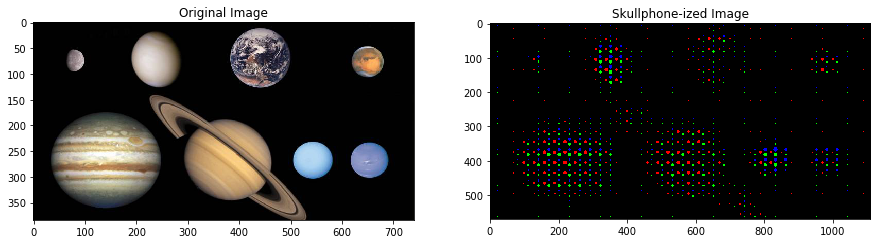

In [11]:
# Main cell

# Get user input (TEST_IMAGE, IMAGE_SCALE)
# TEST_IMAGE_IN = Image.open(sys.argv[1])
# IMAGE_SCALE_IN = sys.argv[2]
    
# Call skullphonize_img()
processed_img = skullphonize_img(TEST_IMAGE, IMAGE_SCALE)

# Output resulting image
if processed_img is not None:
    fig = plt.figure(figsize = (15,30))
    p_orig = fig.add_subplot(2,2,1)
    p_orig.set_title("Original Image")
    img = plt.imread(TEST_IMAGE, 0)
    plt.imshow(img) 
    p_scaled = fig.add_subplot(2,2,2)
    p_scaled.set_title("Skullphone-ized Image")
    plt.imshow(processed_img) 
    plt.show()

else:
    print("Error with file type.")